['images', 'data', 'target_names', 'DESCR', 'target']
(1797L, 64L)
(1797L,)
[  0.   5.  12.  13.  16.  16.   2.   0.   0.  11.  16.  15.   8.   4.   0.
   0.   0.   8.  14.  11.   1.   0.   0.   0.   0.   8.  16.  16.  14.   0.
   0.   0.   0.   1.   6.   6.  16.   0.   0.   0.   0.   0.   0.   5.  16.
   3.   0.   0.   0.   1.   5.  15.  13.   0.   0.   0.   0.   4.  15.  16.
   2.   0.   0.   0.]
the images 15 is 5


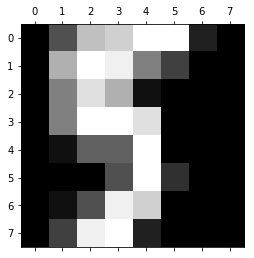

In [1]:
#本文是神经网络算法，实现手写字体识别
#load the datasets
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()
print digits.keys()
data = digits.data
target = digits.target

print data.shape
print target.shape
print data[15]
print "the images 15 is",target[15]
plt.gray()
plt.matshow(digits.images[15])
plt.show()



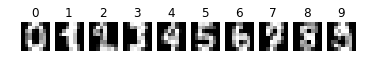

In [2]:
#随机选出每一类的一个样本看看长什么样子
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 1
for y, cla in enumerate(classes):
    idxs = np.flatnonzero(target == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(digits.images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cla)
plt.show()

In [3]:
#这里我整理成了一个class
#implement the neural network
def sigmoid(x):
    return 1/(1+np.exp(-x))
#sigmoid的倒数函数
def dsigmoid(x):
    return x*(1-x)

class NeuralNetwork(object):
    def __init__(self,input_size,hidden_size,output_size):
        #小数随机初始化参数，不能全0，打破对称性
        self.W1 = 0.01 * np.random.randn(input_size,hidden_size)#D*H
        self.b1 = np.zeros(hidden_size) #H ,(参数b=0没有关系)
        self.W2 = 0.01 * np.random.randn(hidden_size,output_size)#H*C
        self.b2 = np.zeros(output_size)#C
    
    def loss(self,X,y,reg = 0.01):
        num_train, num_feature = X.shape
        #forward前向传播
        a1 = X  #input layer:N*D
        a2 = sigmoid(a1.dot(self.W1) + self.b1) #hidden layer:N*H
        a3 = sigmoid(a2.dot(self.W2) + self.b2) #output layer:N*C
        
        loss = - np.sum(y*np.log(a3) + (1-y)*np.log((1-a3)))/num_train
        loss += 0.5 * reg * (np.sum(self.W1*self.W1)+np.sum(self.W2*self.W2)) / num_train
        
        #backward,后向传播过程
        error3 = a3 - y #N*C
        dW2 = a2.T.dot(error3) + reg * self.W2#(H*N)*(N*C)=H*C
        db2 = np.sum(error3,axis=0)
        
        error2 = error3.dot(self.W2.T)*dsigmoid(a2) #N*H
        dW1 = a1.T.dot(error2) + reg * self.W1     #(D*N)*(N*H) =D*H
        db1 = np.sum(error2,axis=0)
        
        dW1 /= num_train
        dW2 /= num_train
        db1 /= num_train
        db2 /= num_train
        
        return loss,dW1,dW2,db1,db2
    #训练过程,并且没500次，统计一下train_acc和val_acc
    def train(self,X,y,y_train,X_val,y_val,learn_rate=0.01,num_iters = 10000):
        batch_size = 150
        num_train = X.shape[0]
        loss_list = []
        accuracy_train = []
        accuracy_val = []
        
        for i in xrange(num_iters):
            #每次随机的选取小样本batch set去训练
            batch_index = np.random.choice(num_train,batch_size,replace=True)
            X_batch = X[batch_index]
            y_batch = y[batch_index]
            y_train_batch = y_train[batch_index]
            
            loss,dW1,dW2,db1,db2 = self.loss(X_batch,y_batch)
            loss_list.append(loss)
            
            #update the weight
            self.W1 += -learn_rate*dW1
            self.W2 += -learn_rate*dW2
            self.b1 += -learn_rate*db1
            self.b2 += -learn_rate*db2
            
            if i%500 == 0:
                print "i=%d,loss=%f" %(i,loss)
                #record the train accuracy and validation accuracy
                train_acc = np.mean(y_train_batch==self.predict(X_batch))
                val_acc = np.mean(y_val==self.predict(X_val))
                accuracy_train.append(train_acc)
                accuracy_val.append(val_acc)
                
        return loss_list,accuracy_train,accuracy_val
    #预测一下，多分类的预测，取得最大值的下标为分类结果
    def predict(self,X_test):
        a2 = sigmoid(X_test.dot(self.W1) + self.b1)
        a3 = sigmoid(a2.dot(self.W2) + self.b2)
        y_pred = np.argmax(a3,axis=1)
        return y_pred
        
        
    pass

   
    


In [4]:
from sklearn.preprocessing import LabelBinarizer
#定义一下数值梯度，用于梯度检查
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 
    
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore
        
        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
          print ix, grad[ix]
        it.iternext() # step to next dimension
    return grad
#定义一下比较函数，用于两个梯度的对比
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
#模拟一个小网络，进行梯度检查，这样的话，可以判断模型正确性
input_size = 4
hidden_size = 10
output_size = 3
num_train = 5

def init_toy_model():
  np.random.seed(0)
  return NeuralNetwork(input_size, hidden_size, output_size)

def init_toy_data():
  np.random.seed(1)
  XX = 10 * np.random.randn(num_train, input_size)
  yy = np.array([0, 1, 2, 2, 1])
  return XX, yy

net = init_toy_model()
XX, yy = init_toy_data()
yy_label = LabelBinarizer().fit_transform(yy)

loss,dW1,dW2,db1,db2 = net.loss(XX,yy_label)
f = lambda W: net.loss(XX, yy_label)[0] #f(w) = loss
dW1_ = eval_numerical_gradient(f,net.W1,verbose=False)
dW2_ = eval_numerical_gradient(f,net.W2,verbose=False)
db1_ = eval_numerical_gradient(f,net.b1,verbose=False)
db2_ = eval_numerical_gradient(f,net.b2,verbose=False)

print '%s max relative error: %e' % ('W1', rel_error(dW1, dW1_))
print '%s max relative error: %e' % ('W2', rel_error(dW2, dW2_))
print '%s max relative error: %e' % ('b1', rel_error(db1, db1_))
print '%s max relative error: %e' % ('b2', rel_error(db2, db2_))

W1 max relative error: 1.812071e-08
W2 max relative error: 3.958839e-10
b1 max relative error: 7.817713e-08
b2 max relative error: 5.888433e-11


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
X = data
y = target
#normalized 数据集合0均值化
X_mean = np.mean(X,axis=0)
X -= X_mean
#分隔数据集合，分为train，val,test集合
X_data,X_test,y_data,y_test = train_test_split(X,y,test_size=0.2)
#split the train and tne validation
X_train = X_data[0:1000]
y_train = y_data[0:1000]
X_val = X_data[1000:-1]
y_val = y_data[1000:-1]

print X_train.shape,X_val.shape,X_test.shape
#进行标签二值化，1-->[0,1,0,0,0,0,0,0,0,0]   5=[0,0,0,0,0,1,0,0,0,0]
y_train_label = LabelBinarizer().fit_transform(y_train)

classify = NeuralNetwork(X.shape[1],100,10)
#数据准备完毕，开始训练
print 'start'

loss_list,accuracy_train,accuracy_val = classify.train(X_train,y_train_label
                                                       ,y_train,X_val,y_val)


print 'end'





(1000L, 64L) (436L, 64L) (360L, 64L)
start


i=0,loss=7.060120


i=500,loss=2.020329


i=1000,loss=1.208715


i=1500,loss=0.711440


i=2000,loss=0.608078


i=2500,loss=0.493830


i=3000,loss=0.404080


i=3500,loss=0.328199


i=4000,loss=0.307644


i=4500,loss=0.224095


i=5000,loss=0.224976


i=5500,loss=0.211779


i=6000,loss=0.183015


i=6500,loss=0.188465


i=7000,loss=0.179562


i=7500,loss=0.165125


i=8000,loss=0.164741


i=8500,loss=0.112698


i=9000,loss=0.127080


i=9500,loss=0.113350


end


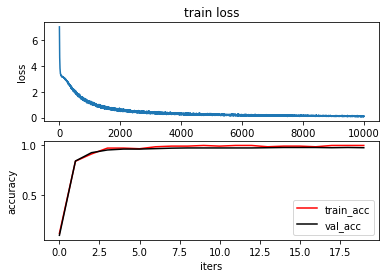

In [6]:
#可视化一下训练结果
import matplotlib.pyplot as plt

plt.subplot(211)
plt.plot(loss_list)
plt.title('train loss')
plt.xlabel('iters')
plt.ylabel('loss')

plt.subplot(212)
plt.plot(accuracy_train,label = 'train_acc',color = 'red')
plt.plot(accuracy_val,label = 'val_acc', color = 'black')
plt.xlabel('iters')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')

plt.show()


In [7]:
#预测一下，并且看看正确率
y_pred = classify.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print "the accuracy is ",accuracy
        
    


the accuracy is  0.966666666667


In [22]:
#随机挑选样本，看看预测结果
m,n = data.shape
example_size = 10
example_index = np.random.choice(m,example_size)
print example_index
for i, idx in enumerate(example_index):
    
    print "%d example is number %d,we predict it as %d"\
          %(i,target[idx],classify.predict(X[idx,:].reshape(1,-1)))
    



[ 946  572  772  404  492 1796  808 1720 1507 1465]
0 example is number 4,we predict it as 4
1 example is number 1,we predict it as 1
2 example is number 0,we predict it as 0
3 example is number 8,we predict it as 8
4 example is number 6,we predict it as 6
5 example is number 8,we predict it as 8
6 example is number 5,we predict it as 5
7 example is number 8,we predict it as 8
8 example is number 9,we predict it as 9
9 example is number 2,we predict it as 2
